In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
#branch = "pyro-cell2location"
#user = "vitkl"
#IN_COLAB = "google.colab" in sys.modules
#IN_COLAB = True

#if IN_COLAB and branch == "stable":
#    !pip install --quiet scvi-tools[tutorials]
#elif IN_COLAB and branch != "stable":
#    !pip install --quiet --upgrade jsonschema
#    !pip install --quiet git+https://github.com/$user/scvi-tools@$branch#egg=scvi-tools[tutorials]
        
#import sys
#if not IN_COLAB:

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

#import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

In [2]:
import scipy.sparse
import matplotlib
from functools import partial
from scipy import interpolate
from itertools import cycle
import pyro

%config InlineBackend.figure_format='retina'

In [3]:
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_data/mouse_visium_snrna/'
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/data/'
sc_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/'

scvi_run_name = f'{results_folder}test_regression_normalisation_adam_lr0002_test_data'

fig_path = f'{results_folder}hyperparameter_plots/'

In [4]:
adata = anndata.read(f'{sp_data_folder}synth_adata_real_mg_20210131.h5ad')
adata_vis = adata[adata.obs['sample']=='exper0']
adata_vis.uns['spatial'] = {'x': 'y'}

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


In [5]:
# Save anndata object with signatures
adata_file = f"{scvi_run_name}_ref/sc.h5ad"
adata_snrna_raw = sc.read_h5ad(adata_file)

# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    regr_inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    regr_inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
regr_inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
regr_inf_aver.iloc[0:5, 0:5]

,Astro_AMY,Astro_AMY_CTX,Astro_CTX,Astro_HPC,Astro_HYPO
ENSEMBL,,,,,
ENSMUSG00000051951,0.050511,0.105329,0.039299,0.176706,0.032688
ENSMUSG00000089699,0.031588,0.025723,0.008132,0.014632,0.032263
ENSMUSG00000033845,0.140224,0.064763,0.073241,0.065900,0.087580
ENSMUSG00000033813,0.085916,0.130148,0.180947,0.105858,0.070225
ENSMUSG00000002459,2.846514,3.509084,3.756964,4.002057,1.390353


In [6]:
# rename genes to ENSEMBL
adata_vis.var['SYMBOL'] = adata_vis.var_names

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, regr_inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
regr_inf_aver = regr_inf_aver.loc[intersect, :].copy()

# prepare anndata for scVI model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2500 cells, 12080 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [7]:
regr_inf_aver.shape

(12080, 49)

In [8]:
from scvi.external.cell2location._cell2location_v3_no_factorisation_module import LocationModelMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel
from scvi.external.cell2location._cell2location_v3_no_mg_module import LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelNoMGPyroModel
from scvi.external.cell2location._cell2location_v3_module import LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel


model_list = [LocationModelMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel, 
              LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelNoMGPyroModel, 
              LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel]

conditions_df = pd.DataFrame({
    'model': model_list,
    'alpha': [200 for i in model_list],
    'lr': [0.002 for i in model_list],
    'max_epochs': [20000, 50000, 40000],
    'clip_norm': [None for i in model_list],
    'inf_aver': [regr_inf_aver for i in model_list],
    'names': [f'{i.__name__}' for i in model_list]
})
conditions = [conditions_df.iloc[i, :] for i in range(conditions_df.shape[0])]
conditions

[model         <class 'scvi.external.cell2location._cell2loca...
 alpha                                                       200
 lr                                                        0.002
 max_epochs                                                20000
 clip_norm                                                  None
 inf_aver                          Astro_AMY  Astro_AMY_CTX  ...
 names         LocationModelMultiExperimentLocationBackground...
 Name: 0, dtype: object,
 model         <class 'scvi.external.cell2location._cell2loca...
 alpha                                                       200
 lr                                                        0.002
 max_epochs                                                50000
 clip_norm                                                  None
 inf_aver                          Astro_AMY  Astro_AMY_CTX  ...
 names         LocationModelLinearDependentWMultiExperimentLo...
 Name: 1, dtype: object,
 model         <class 'scvi.external.cel

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:16<00:00, 61.83it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 65.82it/s]


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 62.46it/s]


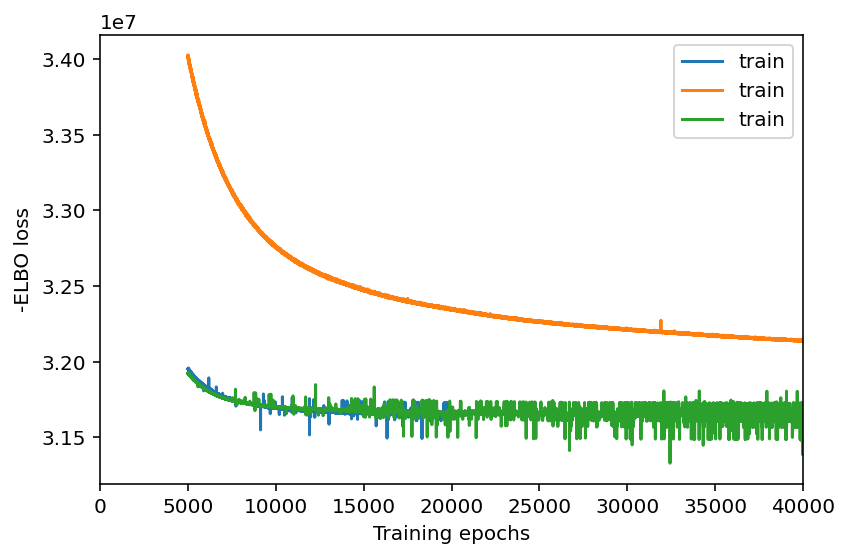

In [9]:
pyro.clear_param_store()

history = []

for con in conditions:
    
    ########### REGRESSION MODEL #############
    
    ########### CELL2LOCATION MODEL #############
    mod = scvi.external.Cell2location(
        adata_vis, cell_state_df=con['inf_aver'], 
        model_class=con['model'],
        amortised=False, #encoder_mode="single-multiple",
       # encoder_kwargs={'dropout_rate': 0.2},
        # the expected average cell abundance - user-provided, tissue-dependent hyper-prior:
        N_cells_per_location=9,
        detection_alpha=con["alpha"],
    ) 
    mod.train(max_epochs=con['max_epochs'], 
              batch_size=None, 
              train_size=1,
              #plan_kwargs={
              #    'optim': pyro.optim.ClippedAdam({
              #        'lr': con['lr'], 
              #        'clip_norm': con['clip_norm']
              #    })
              #},
              plan_kwargs={'optim': pyro.optim.Adam({'lr': con['lr']})},
              use_gpu=True
    )
    mod.plot_history(5000)
    #history += list(mod.history['elbo_train'].values[:, 0])

    adata_vis_res = mod.export_posterior(
        adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True})

    scvi_run_name = f'{results_folder}test_simplified2_alpha{con["alpha"]}_lr{con["lr"]}_max_epochs{con["max_epochs"]}_{con["names"]}_test_data'

    mod.save(f"{scvi_run_name}", overwrite=True)
    adata_file = f"{scvi_run_name}/sp.h5ad"
    adata_vis_res.write(adata_file)

# Collect data 

In [9]:
from glob import glob
from re import sub

#dir_names = sorted(glob(f'{results_folder}test_simplified2_alpha*_max_epochs*')) 
                   #+ glob(f'{results_folder}test_v3_regression_normalisation_adam_alpha_lr0.002_max_epochs70000_alpha200_test_data*'))
dir_names= [
    f'{results_folder}test_simplified2_alpha200_lr0.002_max_epochs40000_LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel_test_data',
    f'{results_folder}test_simplified2_alpha200_lr0.002_max_epochs20000_LocationModelMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel_test_data',
    f'{results_folder}test_simplified2_alpha200_lr0.002_max_epochs50000_LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelNoMGPyroModel_test_data',
]
test_names = [sub('_test_data', '', i)for i in dir_names]
test_names = [sub('^.+/', '', i)for i in test_names]
test_names = [sub('^.+_', '', i)for i in test_names]
method_dfs = []
method_count_dfs = []

for dir_name in dir_names:
    adata_vis_res = sc.read(f'{dir_name}/sp.h5ad')
    cell_count = adata_vis_res.obs.loc[:, ['cell_abundances_' in i for i in adata_vis_res.obs.columns]]
    cell_count.columns =  [sub('cell_abundances_', '', i) for i in cell_count.columns]
    cell_count_columns = cell_count.columns
    cell_proportions = (cell_count.T / cell_count.sum(1)).T
    cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0
    
    spot_factors = adata_vis_res.obsm['q05_cell_abundance_w_sf']
    spot_factors.columns =  [sub('q05cell_abundance_w_sf_', '', i) for i in spot_factors.columns]
    infer_cell_count = spot_factors[cell_count.columns]
    infer_cell_proportions = (infer_cell_count.T / infer_cell_count.sum(1)).T
    
    method_dfs.append(infer_cell_proportions)
    method_count_dfs.append(infer_cell_count)
    
test_names, dir_names

(['LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel',
  'LocationModelMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel',
  'LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelNoMGPyroModel'],
 ['/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/test_simplified2_alpha200_lr0.002_max_epochs40000_LocationModelLinearDependentWMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel_test_data',
  '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/test_simplified2_alpha200_lr0.002_max_epochs20000_LocationModelMultiExperimentLocationBackgroundNormLevelGeneAlphaPyroModel_test_data',
  '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/test_simplified2_alpha200_lr0.002_max_epochs50000_LocationModelLin

In [10]:
np.all(cell_count.columns == method_dfs[0].columns)

True

# Plotting functions

In [11]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True, max_val=1):
    
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    title = title +'\n'+ r'$R^2$: ' + str(cor)
    
    if compute_kl:
        
        #kl = [KL(cell_count.values[r,:], infer_cell_count.values[r,:]) 
        #         for r in range(cell_count.shape[0])]
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        #kl = np.mean(kl)
        js = np.mean(js[~np.isnan(js)])
        #title = title + '\nAverage KL: ' + str(np.round(kl, 2))
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    plt.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[35, 35], norm=matplotlib.colors.LogNorm());
    plt.xlabel(xlab);
    plt.ylabel(ylab);
    if equal:
        plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim(0, max_val);
    plt.ylim(0, max_val);
    plt.title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True):

    design_loc = design.loc[cell_count.columns,:]
    
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Uniform & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    
    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title=f'Sparse & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val)
    

# rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
# rcParams["axes.facecolor"] = "white"
# hist_by_category(cell_proportions, infer_cell_proportions, adata_vis_res.uns['design']['cell_types2zones'],
#                  xlab='Simulated cell proportion',
#                  ylab='Inferred cell proportion',
#                  #compute_kl=False, 
#                  nrow=1, ncol=4, equal=True)
# plt.tight_layout()

#plt.savefig(fig_path + '/hist_by_category.pdf')

In [12]:
def plot_precision_recall(pos_cell_count, infer_cell_proportions,
                          title='', individual_cell_types=True,
                          mode='macro', curve='PR', 
                          ax=None, save=None):
    r""" Plot precision-recall curves on average and for each cell type.
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    :param title: plot title
    :param iso_f1_curves: plot iso curves for F1 score?
    :param individual_cell_types: show precision-recall curves for each cell type?
    """
    
    ### calculating ###
    if curve == 'PR':
        xlabel = 'Recall'
        ylabel = 'Precision'
        
    elif curve == 'ROC':
        xlabel = 'FPR'
        ylabel = 'TPR'
    
    X, Y, scores = compute_curve(pos_cell_count, infer_cell_proportions, mode=mode, curve=curve)
    
    ### plotting ###
    if ax is None:
        ax = plt.gca()
        
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    lines = []
    labels = []
    
    l = ax.plot(X["averaged"], Y["averaged"], color='navy', lw=2)
    lines.append(l[0])
    labels.append(f'{mode}-average {curve} ({curve} score = {scores["averaged"] :.2f})')

    if individual_cell_types:
        for i, color in zip(infer_cell_proportions.columns, colors):
            l = ax.plot(X[i], Y[i], color='gold', lw=1)
        lines.append(l[0])
        labels.append(f'{curve} for individual cell types')
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(lines, labels, loc=(0, -.37), prop=dict(size=8))

    if save is not None:
        plt.savefig(save)
        
    return ax

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

def swap_return_order(f, order, *args, **kwargs):
    result = f(*args, **kwargs)
    return [result[i] for i in order]


def compute_curve(pos_cell_count, infer_cell_proportions, mode='macro', curve='AUC'):
    r"""
    :param pos_cell_count: binary matrix showing which cell types are present in which locations
    :param infer_cell_proportions: inferred locations (the higher the more cells)
    """
    predictor = infer_cell_proportions.values + np.random.gamma(20, 1e-12, infer_cell_proportions.shape)
    
    X = dict()
    Y = dict()
    scores = dict()
    
    if curve == 'ROC':
        # in this case X is FPR and Y is TPR
        curve_function = partial(swap_return_order, roc_curve, [1, 0, 2])
        score_function = roc_auc_score
        
    elif curve == 'PR':
        # in this case X is recall and Y is precision
        curve_function = precision_recall_curve
        score_function = average_precision_score
        
    for i, c in enumerate(infer_cell_proportions.columns):
        Y[c], X[c], _ = curve_function(pos_cell_count[:, i], predictor[:, i])
        scores[c] = score_function(pos_cell_count[:, i], predictor[:, i], average=mode)

    scores["averaged"] = score_function(pos_cell_count, predictor, average=mode)
    
    if mode == 'micro':
        Y["averaged"], X["averaged"], _ = roc_curve(pos_cell_count.ravel(), predictor.ravel())

    elif mode == 'macro':
        Ys = []
        x_grid = np.linspace(0, 1, 2000)
        for i, c in enumerate(infer_cell_proportions.columns):
            f = interpolate.interp1d(X[c], Y[c])
            y_interp = f(x_grid)
            Ys.append(y_interp)

        X["averaged"] = x_grid
        Y['averaged'] = np.mean(Ys, axis=0)
    return X, Y, scores 

compute_roc = partial(compute_curve, curve='ROC')
compute_precision_recall = partial(compute_curve, curve='PR')

In [13]:
def roc_by_category(pos_cell_count, infer_cell_count, design,
                   nrow=5, ncol=1, title='', fig_path='', legend=True):

    design_loc = design.loc[cell_count.columns,:]
    plt.figure(figsize=(14, 4))
    plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'Uniform & high abundance ({ind.sum()})', curve='ROC',
                          #save=fig_path + '/Uniform_low_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'Uniform & low abundance ({ind.sum()})', curve='ROC',
                          #save=fig_path + '/Uniform_high_abundance.pdf'
                         )
    
    plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'Sparse & high abundance ({ind.sum()})', curve='ROC',
                          #save=fig_path + '/Segregated_low_abundance.pdf'
                         )

    plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    plot_precision_recall(pos_cell_count[:, ind], infer_cell_count.loc[:,ind],
                          title=f'Sparse & low abundance ({ind.sum()})', curve='ROC',
                          #save=fig_path + '/Segregated_high_abundance.pdf'
                         )
    if not legend:
        for ax in plt.gcf().axes:
            ax.get_legend().remove()

def calculate_r2(cell_count, infer_cell_count):
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    return cor

def calculate_rmse(cell_count, infer_cell_count):
    rmse_sq = ((cell_count.values.flatten() - infer_cell_count.values.flatten()) ** 2).mean()
    rmse = np.round(np.sqrt(rmse_sq), 3)
    return rmse

def get_stat_for_types_generic(cell_count, infer_cell_count, design, calculate_stat):
    design_loc = design.loc[cell_count.columns,:]
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    
    types_data = {}
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    types_data['Ubiquitous & \nHigh abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    types_data['Ubiquitous & \nLow abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    types_data['Regional & \nHigh abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    types_data['Regional & \nLow abundance'] = calculate_stat(cell_count.loc[:,ind], infer_cell_count.loc[:,ind])
    
    return pd.DataFrame([types_data.values()], columns=types_data.keys(), index=[1])

def change_width(ax, new_value, shrink=0, shift=0):
    """
    Change width/position of barplots 
    """
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        patch.set_x(patch.get_x() + shrink * (round(patch.get_x()) - patch.get_x()) - shift)
        
def show_values_on_bars(axs, text_size=9):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.01
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center", size=text_size) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Compute metrics 

In [14]:
adata_vis_res.uns['design']['cell_types2zones'].index

Index(['Inh_3', 'Ext_Pir', 'Oligo_2', 'Astro_HYPO', 'Ext_L25',
       'Astro_THAL_lat', 'Ext_L5_1', 'Ext_L23', 'Micro', 'Ext_Thal_1',
       'Ext_Hpc_CA1', 'Inh_Meis2_3', 'Inh_4', 'OPC_1', 'Oligo_1',
       'Ext_Hpc_CA3', 'Astro_CTX', 'Astro_THAL_med', 'Inh_Vip', 'Ext_Amy_2',
       'Astro_AMY_CTX', 'Unk_1', 'Inh_Sst', 'Inh_Meis2_2', 'Ext_Hpc_DG2',
       'Ext_Hpc_DG1', 'Inh_1', 'Inh_Meis2_4', 'Inh_2', 'Nb_1', 'Ext_Thal_2',
       'Ext_Amy_1', 'Ext_L6', 'OPC_2', 'Inh_Meis2_1', 'Ext_L6B', 'LowQ_2',
       'Ext_Unk_3', 'Ext_L56', 'Inh_Lamp5', 'Inh_Pvalb', 'Ext_L5_2', 'Inh_6',
       'Astro_AMY', 'Ext_ClauPyr', 'Astro_HPC', 'Astro_WM', 'Nb_2', 'Inh_5'],
      dtype='object')

In [15]:
get_r2_df_short = partial(get_stat_for_types_generic, cell_count=cell_proportions,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=calculate_r2)

r2_data = pd.concat([get_r2_df_short(infer_cell_count=df) for df in method_dfs])
r2_data['method'] = test_names
r2_data_melted = pd.melt(r2_data, id_vars=['method'], value_vars=r2_data.columns[:-1])

In [16]:
get_rmse_df_short = partial(get_stat_for_types_generic, cell_count=cell_count,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=calculate_rmse)

rmse_data = pd.concat([get_rmse_df_short(infer_cell_count=df) for df in method_count_dfs])
rmse_data['method'] = test_names
rmse_data_melted = pd.melt(rmse_data, id_vars=['method'], value_vars=rmse_data.columns[:-1])

In [17]:
pos_cell_count = cell_count > 0.1

cell_proportions = (cell_count.T / cell_count.sum(1)).T
cell_proportions.iloc[np.isnan(cell_proportions.values)] = 0

In [18]:
get_PR = lambda x, y: compute_precision_recall(x.values, y, mode='macro')[2]['averaged']

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=get_PR)

pr_data = pd.concat([get_PR_df_short(infer_cell_count=df) for df in method_dfs])
pr_data['method'] = test_names
pr_data_melted = pd.melt(pr_data, id_vars=['method'], value_vars=pr_data.columns[:-1])


# Plot plots 

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


Astro_AMY_CTX      18.950539
Astro_HPC          18.950539
Astro_AMY          20.460659
Astro_HYPO         23.496923
Astro_THAL_lat     23.496923
Astro_CTX          25.346601
Astro_WM           31.316899
Micro              36.510626
Unk_1              36.510626
Astro_THAL_med     44.849506
Nb_1               50.145761
Nb_2               52.677877
Inh_Meis2_3        58.232795
Inh_Meis2_2        58.232795
OPC_1              59.247595
Inh_4              59.715039
Inh_1              59.715039
Oligo_2            66.789819
Inh_3              70.821201
Ext_L5_1           76.318284
Ext_L6B            76.318284
Inh_Meis2_1        81.632945
Ext_L6             82.228228
Ext_L5_2           82.228228
Ext_L25            91.323967
Inh_Vip            95.562322
Inh_Lamp5          95.562322
Inh_Sst            98.263779
Inh_2              98.263779
LowQ_2             98.421981
Inh_6             102.375499
Inh_5             107.496901
Ext_Hpc_DG2       109.820700
Ext_L56           113.384848
Ext_Unk_3     

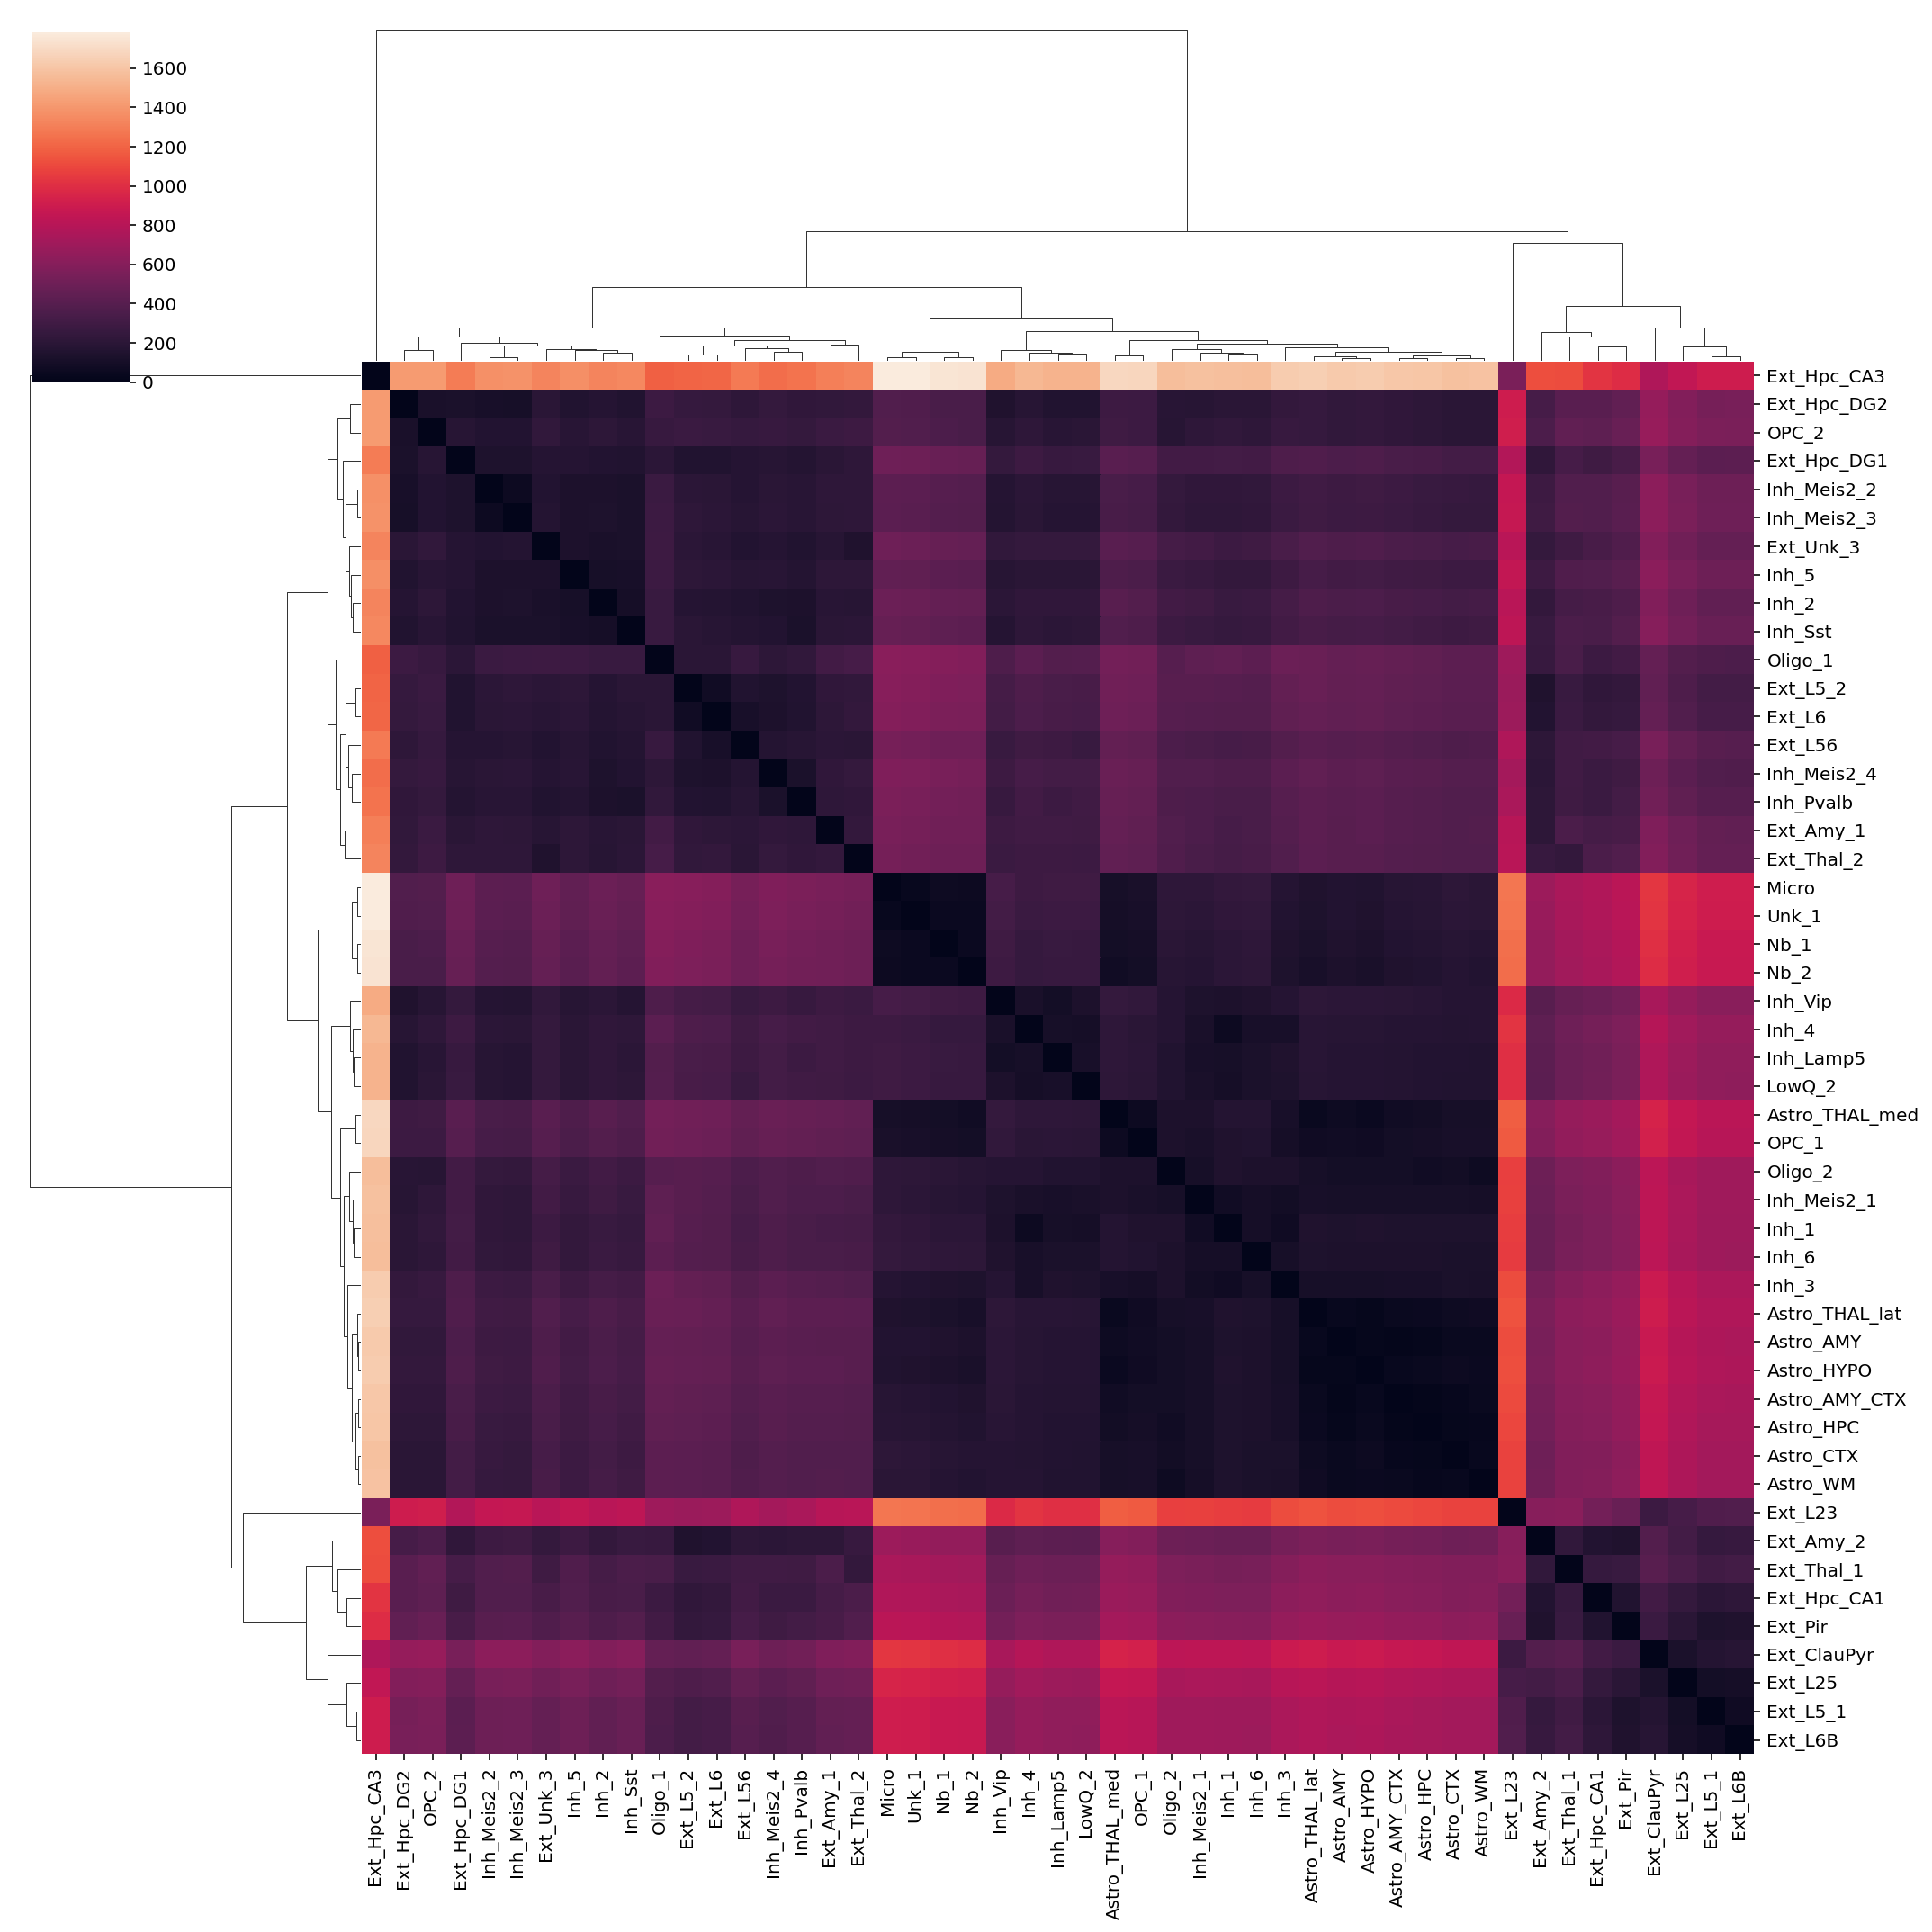

In [19]:
from scipy.spatial.distance import cdist
ct_dist = cdist(regr_inf_aver.T, regr_inf_aver.T, metric='euclidean')
ct_dist = pd.DataFrame(ct_dist, index=regr_inf_aver.columns, columns=regr_inf_aver.columns)

sns.clustermap(ct_dist, figsize=(15, 15))

design = pd.DataFrame(np.array(
    [[ct_dist[c].sort_values()[1:4].mean() for c in ct_dist.columns],
     [ct_dist[c].sort_values()[1].mean() for c in ct_dist.columns]]
).T,
             index=ct_dist.columns, columns=['top3_average_distance', 'min_distance'])

design['is_txn_fine'] = 1-np.digitize(design['min_distance'].values,
                                      [100]
                                      #np.histogram(distinctiveness['min_distance'].values, bins=4)[1]
                                     )
design, design['is_txn_fine'].value_counts()

design['min_distance'].sort_values()

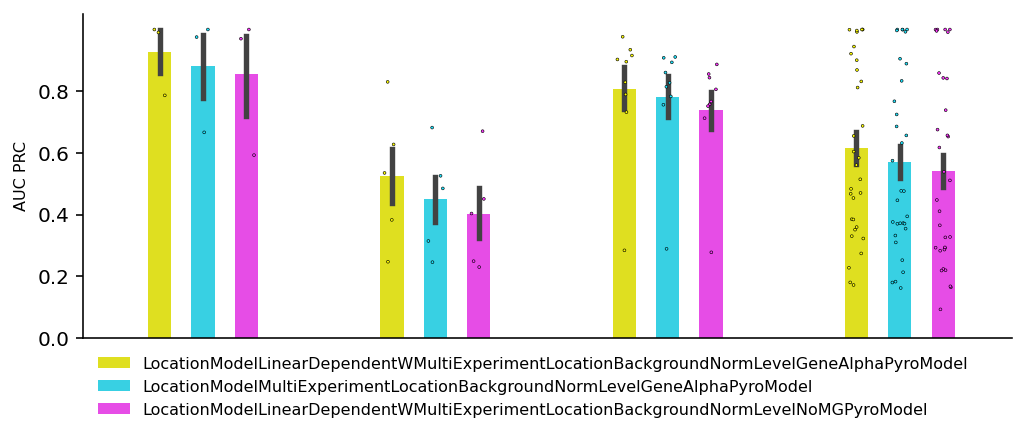

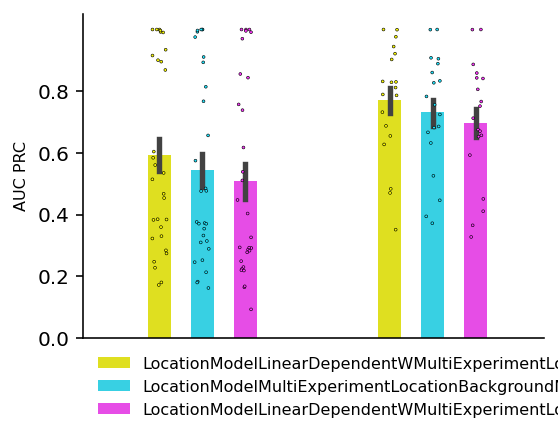

In [24]:
def remove_avg(d):
    d.pop('averaged')
    return d

def change_width(ax, new_value, shrink=0, shift=0, scatter=True, allow_patch=True):
    """
    Change width/position of barplots 
    """
    
    patches = sorted(ax.patches, key=lambda x: x.get_x())
    lines = sorted(ax.lines, key=lambda x: x.get_xdata().mean())
    if scatter:
        collections = sorted(ax.collections, key=lambda x: x.get_offsets()[:, 0].mean())
        iterator = zip(range(100), patches, lines, collections)
    else:
        iterator = zip(range(100), patches, lines, range(100))
    
    for num, patch, line, coll in iterator:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        x_orig = patch.get_x()
        patch.set_x(x_orig + diff * .5)
        x_orig = patch.get_x()
        if allow_patch:
            patch.set_x(x_orig + shrink * (round(x_orig) - x_orig) + shift)
            line.set_xdata(line.get_xdata() + shrink * (np.round(x_orig) - x_orig) + shift)
        if scatter:
            coll._offsets[:, 0] = coll._offsets[:, 0] + shrink * (np.round(x_orig) - x_orig) + shift
        
#         if num % 2 == 0:
#             coll._offsets[:, 0] = coll._offsets[:, 0] + shrink * (np.round(x_orig) - x_orig)
#         else:
#             coll._offsets[:, 0] = coll._offsets[:, 0] - shrink * (np.round(x_orig) - x_orig)

get_PR_values = lambda x, y: list(remove_avg(compute_precision_recall(x.values, y, mode='macro')[2]).values())

get_PR_df_short = partial(get_stat_for_types_generic, cell_count=pos_cell_count,
                          design=adata_vis_res.uns['design']['cell_types2zones'],
                          calculate_stat=get_PR_values)

dfs_detailed = []
for df, method in zip(method_dfs, test_names):
    df_detailed = pd.DataFrame({'value': get_PR_values(pos_cell_count, df)})
    df_detailed['cell_type'] = df.columns
    df_detailed['is_uniform'] = adata_vis_res.uns['design']['cell_types2zones']['is_uniform'][df.columns].values
    df_detailed['is_high_density'] = adata_vis_res.uns['design']['cell_types2zones']['is_high_density'][df.columns].values
    df_detailed['is_txn_fine'] = design['is_txn_fine'][df.columns].values
    df_detailed['max_density'] = adata_vis_res.uns['design']['cell_types2zones'].drop(columns=['is_uniform', 'is_high_density']).max(1)[df.columns].values
    df_detailed['method'] = method
    
    df_detailed['value_normalised_by_density'] = df_detailed['value'] / df_detailed['max_density']
    
    dfs_detailed.append(df_detailed)
pr_data_values = pd.concat(dfs_detailed)

pr_data_values['Fig1_categories'] = ''
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nHigh abundance'
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (~ pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nLow abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nHigh abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (~pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nLow abundance'
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].astype('category')
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].cat.reorder_categories([
    'Ubiquitous & \nHigh abundance', 'Ubiquitous & \nLow abundance',
    'Regional & \nHigh abundance', 'Regional & \nLow abundance'
])

pr_data_values['Fig1_txn_categories'] = ''
pr_data_values.loc[pr_data_values['is_txn_fine'] == 1, 'Fig1_txn_categories'] = \
'Txn fine-grained'
pr_data_values.loc[pr_data_values['is_txn_fine'] == 0, 'Fig1_txn_categories'] = \
'Txn distict'
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].astype('category')
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].cat.reorder_categories([
    'Txn fine-grained', 'Txn distict'
])

def plot_boxplot_prc(x, y="value", n_leged_col=6):
    g = sns.barplot(x=x, y=y,
                    hue="method", ci=68,
                    data=pr_data_values, palette=sc.pl.palettes.default_102);
    h, l = g.get_legend_handles_labels()
    g = sns.stripplot(x=x, y=y, 
                      hue="method", 
                      size=1.4,
                      dodge=True,
                      data=pr_data_values, jitter=True, palette=sc.pl.palettes.default_102);
#     change_width(g, .05, shrink=-0.0, shift=0.07, scatter=True, allow_patch=False)
#     change_width(g, .05, shrink=-0.0, shift=0, scatter=False, allow_patch=True)
    
    change_width(g, .10, shrink=0.30, shift=0.0, scatter=True, allow_patch=True)   
    for col in g.collections:
        col.set_edgecolors('black')
        col.set_linewidth(0.3)
    plt.xlabel('');
    plt.ylabel('AUC PRC', size=8);
    plt.xticks(size=0, ha='center', y=0);

    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    
    
    lgnd = plt.legend(h, l, loc='center', bbox_to_anchor=(0, -0.2,  1, 0.1), mode='expand', ncol=n_leged_col, 
                      fontsize=8, frameon=False);

    # for handle in lgnd.legendHandles:
    #     handle.set_height(20)
    #     handle.set_width(40)
    #     handle.set_y(-4)
    # 
    plt.tight_layout();

    ax = plt.gca()
    ax.get_xaxis().set_ticks([])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
#     plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')
    
pr_data_values.to_csv(fig_path + '/barplot_simplified_Fig1_categories_PRC_data.csv')
plt.figure(figsize=(7.25, 3.2))
plot_boxplot_prc('Fig1_categories', n_leged_col=1)
plt.savefig(fig_path + '/barplot_simplified_Fig1_abundance_categories_PRC.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4., 3.2))
plot_boxplot_prc('Fig1_txn_categories', n_leged_col=1)
plt.savefig(fig_path + '/barplot_simplified_Fig1_txn_categories_PRC.pdf', bbox_inches='tight')
plt.show()

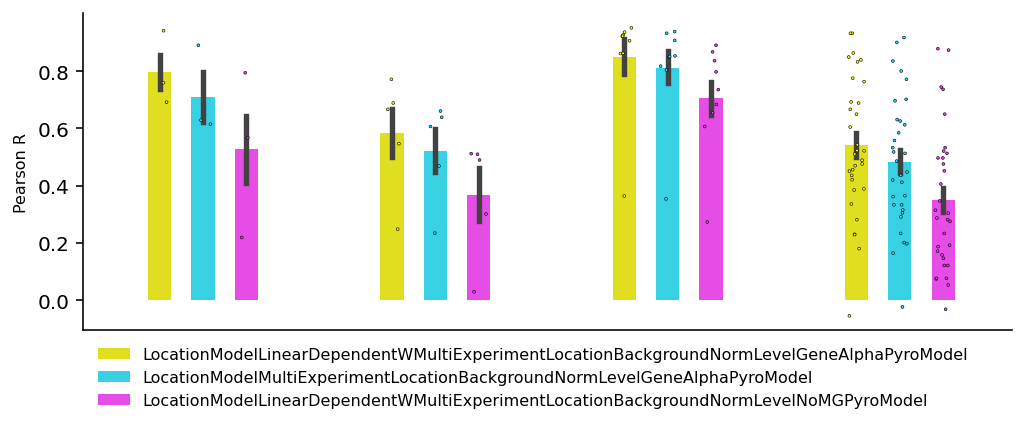

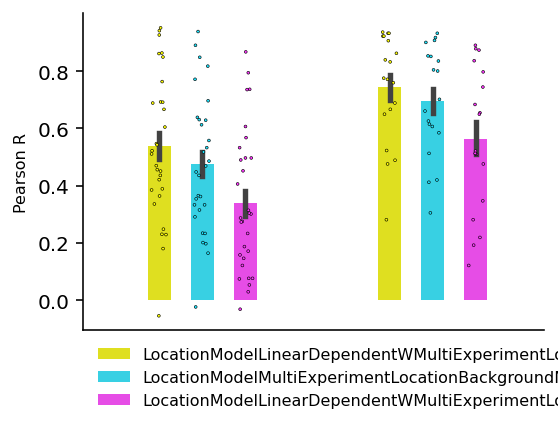

In [25]:
def remove_avg(d):
    d.pop('averaged')
    return d

def change_width(ax, new_value, shrink=0, shift=0, scatter=True, allow_patch=True):
    """
    Change width/position of barplots 
    """
    
    patches = sorted(ax.patches, key=lambda x: x.get_x())
    lines = sorted(ax.lines, key=lambda x: x.get_xdata().mean())
    if scatter:
        collections = sorted(ax.collections, key=lambda x: x.get_offsets()[:, 0].mean())
        iterator = zip(range(100), patches, lines, collections)
    else:
        iterator = zip(range(100), patches, lines, range(100))
    
    for num, patch, line, coll in iterator:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        x_orig = patch.get_x()
        patch.set_x(x_orig + diff * .5)
        x_orig = patch.get_x()
        if allow_patch:
            patch.set_x(x_orig + shrink * (round(x_orig) - x_orig) + shift)
            line.set_xdata(line.get_xdata() + shrink * (np.round(x_orig) - x_orig) + shift)
        if scatter:
            coll._offsets[:, 0] = coll._offsets[:, 0] + shrink * (np.round(x_orig) - x_orig) + shift
        
#         if num % 2 == 0:
#             coll._offsets[:, 0] = coll._offsets[:, 0] + shrink * (np.round(x_orig) - x_orig)
#         else:
#             coll._offsets[:, 0] = coll._offsets[:, 0] - shrink * (np.round(x_orig) - x_orig)
get_PR_values = lambda x, y: np.array([calculate_r2(x.iloc[:,i], y.iloc[:,i]) for i in range(y.shape[1])])

dfs_detailed = []
for df, method in zip(method_dfs, test_names):
    df_detailed = pd.DataFrame({'value': get_PR_values(cell_proportions, df)})
    df_detailed['cell_type'] = df.columns
    df_detailed['is_uniform'] = adata_vis_res.uns['design']['cell_types2zones']['is_uniform'][df.columns].values
    df_detailed['is_high_density'] = adata_vis_res.uns['design']['cell_types2zones']['is_high_density'][df.columns].values
    df_detailed['is_txn_fine'] = design['is_txn_fine'][df.columns].values
    df_detailed['max_density'] = adata_vis_res.uns['design']['cell_types2zones'].drop(columns=['is_uniform', 'is_high_density']).max(1)[df.columns].values
    df_detailed['method'] = method
    
    df_detailed['value_normalised_by_density'] = df_detailed['value'] / df_detailed['max_density']
    
    dfs_detailed.append(df_detailed)
pr_data_values = pd.concat(dfs_detailed)
pr_data_values = pr_data_values.fillna(0)

pr_data_values['Fig1_categories'] = ''
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nHigh abundance'
pr_data_values.loc[(pr_data_values['is_uniform'].astype(bool)) 
                   & (~ pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Ubiquitous & \nLow abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nHigh abundance'
pr_data_values.loc[(~pr_data_values['is_uniform'].astype(bool)) 
                   & (~pr_data_values['is_high_density'].astype(bool)), 'Fig1_categories'] = \
'Regional & \nLow abundance'
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].astype('category')
pr_data_values['Fig1_categories'] = pr_data_values['Fig1_categories'].cat.reorder_categories([
    'Ubiquitous & \nHigh abundance', 'Ubiquitous & \nLow abundance',
    'Regional & \nHigh abundance', 'Regional & \nLow abundance'
])

pr_data_values['Fig1_txn_categories'] = ''
pr_data_values.loc[pr_data_values['is_txn_fine'] == 1, 'Fig1_txn_categories'] = \
'Txn fine-grained'
pr_data_values.loc[pr_data_values['is_txn_fine'] == 0, 'Fig1_txn_categories'] = \
'Txn distict'
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].astype('category')
pr_data_values['Fig1_txn_categories'] = pr_data_values['Fig1_txn_categories'].cat.reorder_categories([
    'Txn fine-grained', 'Txn distict'
])

def plot_boxplot_prc(x, y="value", n_leged_col=6):
    g = sns.barplot(x=x, y=y,
                    hue="method", ci=68,
                    data=pr_data_values, palette=sc.pl.palettes.default_102);
    h, l = g.get_legend_handles_labels()
    g = sns.stripplot(x=x, y=y, 
                      hue="method", 
                      size=1.4,
                      dodge=True,
                      data=pr_data_values, jitter=True, palette=sc.pl.palettes.default_102);
#     change_width(g, .05, shrink=-0.0, shift=0.07, scatter=True, allow_patch=False)
#     change_width(g, .05, shrink=-0.0, shift=0, scatter=False, allow_patch=True)
    
    change_width(g, .10, shrink=0.30, shift=0.0, scatter=True, allow_patch=True)   
    for col in g.collections:
        col.set_edgecolors('black')
        col.set_linewidth(0.3)
    plt.xlabel('');
    plt.ylabel('Pearson R', size=8);
    plt.xticks(size=0, ha='center', y=0);

    g.spines['right'].set_visible(False)
    g.spines['top'].set_visible(False)
    
    
    lgnd = plt.legend(h, l, loc='center', bbox_to_anchor=(0, -0.2,  1, 0.1), mode='expand', ncol=n_leged_col, 
                      fontsize=8, frameon=False);

    # for handle in lgnd.legendHandles:
    #     handle.set_height(20)
    #     handle.set_width(40)
    #     handle.set_y(-4)
    # 
    plt.tight_layout();

    ax = plt.gca()
    ax.get_xaxis().set_ticks([])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
#     plt.savefig(fig_path + '/barplot_by_category_with_label.pdf', bbox_inches='tight')
    
pr_data_values.to_csv(fig_path + '/barplot_simplified_Fig1_categories_R_data.csv')
plt.figure(figsize=(7.25, 3.2))
plot_boxplot_prc('Fig1_categories', n_leged_col=1)
plt.savefig(fig_path + '/barplot_simplified_Fig1_abundance_categories_Pearson_R.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(4., 3.2))
plot_boxplot_prc('Fig1_txn_categories', n_leged_col=1)
plt.savefig(fig_path + '/barplot_simplified_Fig1_txn_categories_Pearson_R.pdf', bbox_inches='tight')
plt.show()

In [23]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/hyperparameter_plots/'

/nfs/team283/vk7/software/miniconda3farm5/envs/scvi-env2/lib/python3.7/site-packages/scipy/spatial/distance.py:1293: RuntimeWarning: invalid value encountered in true_divide
  p = p / np.sum(p, axis=0)


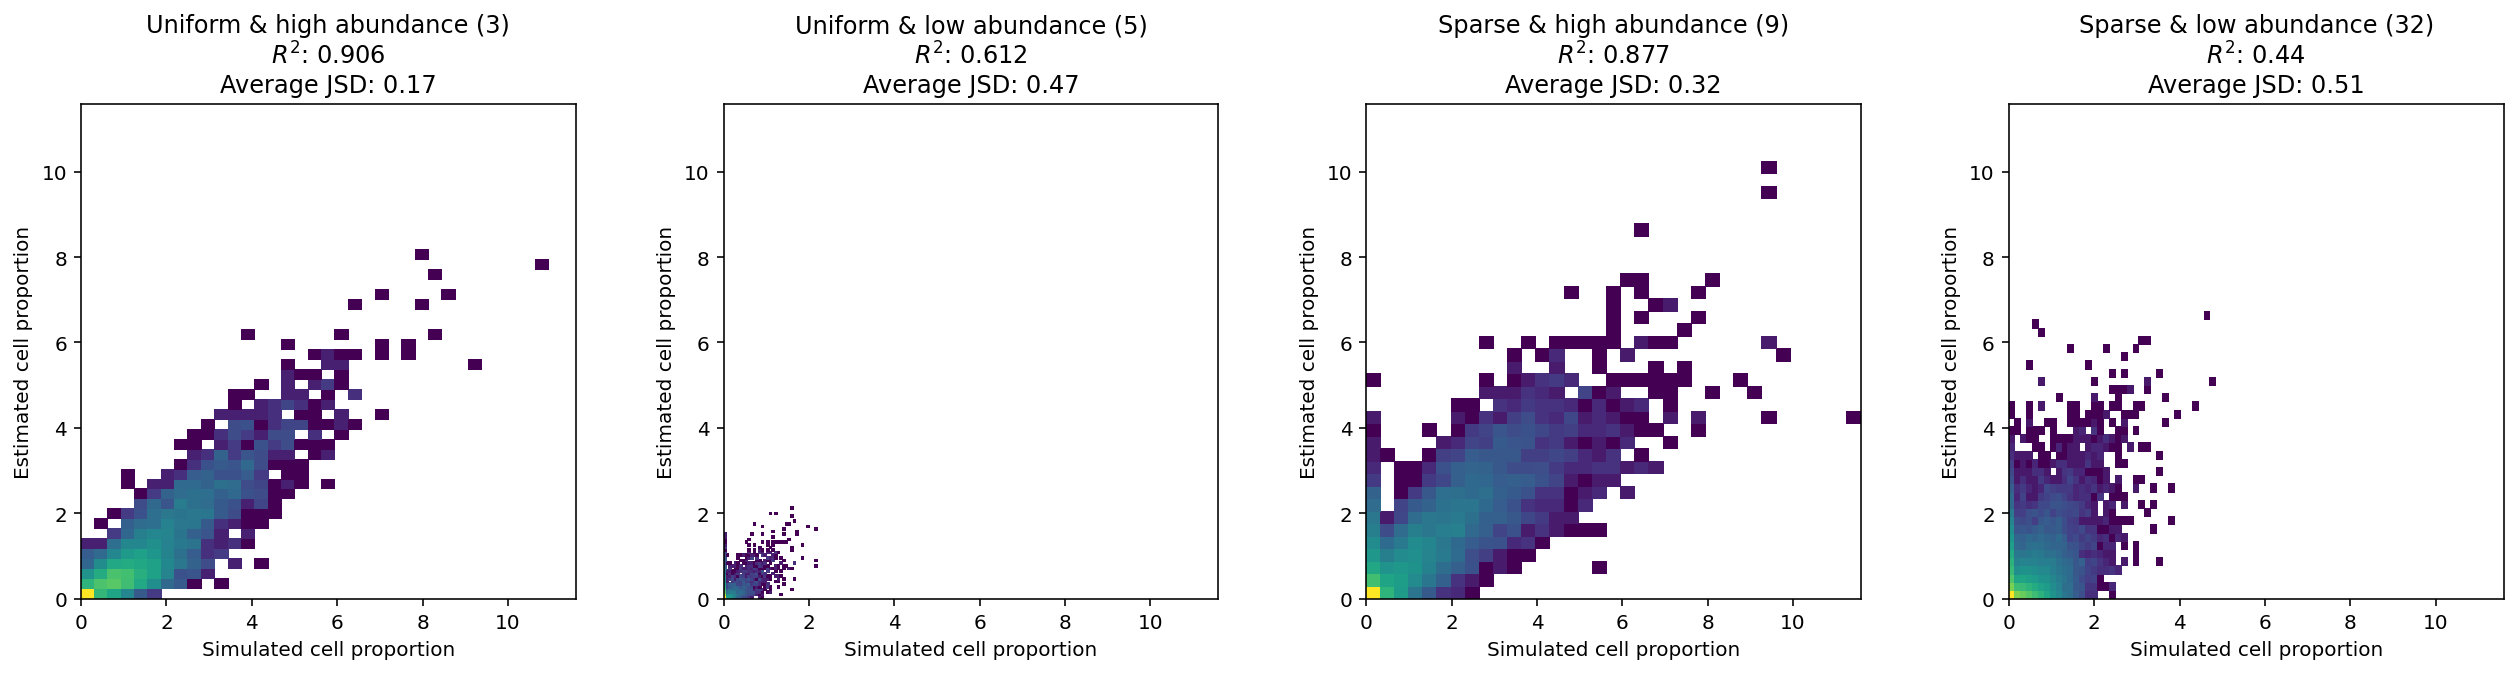

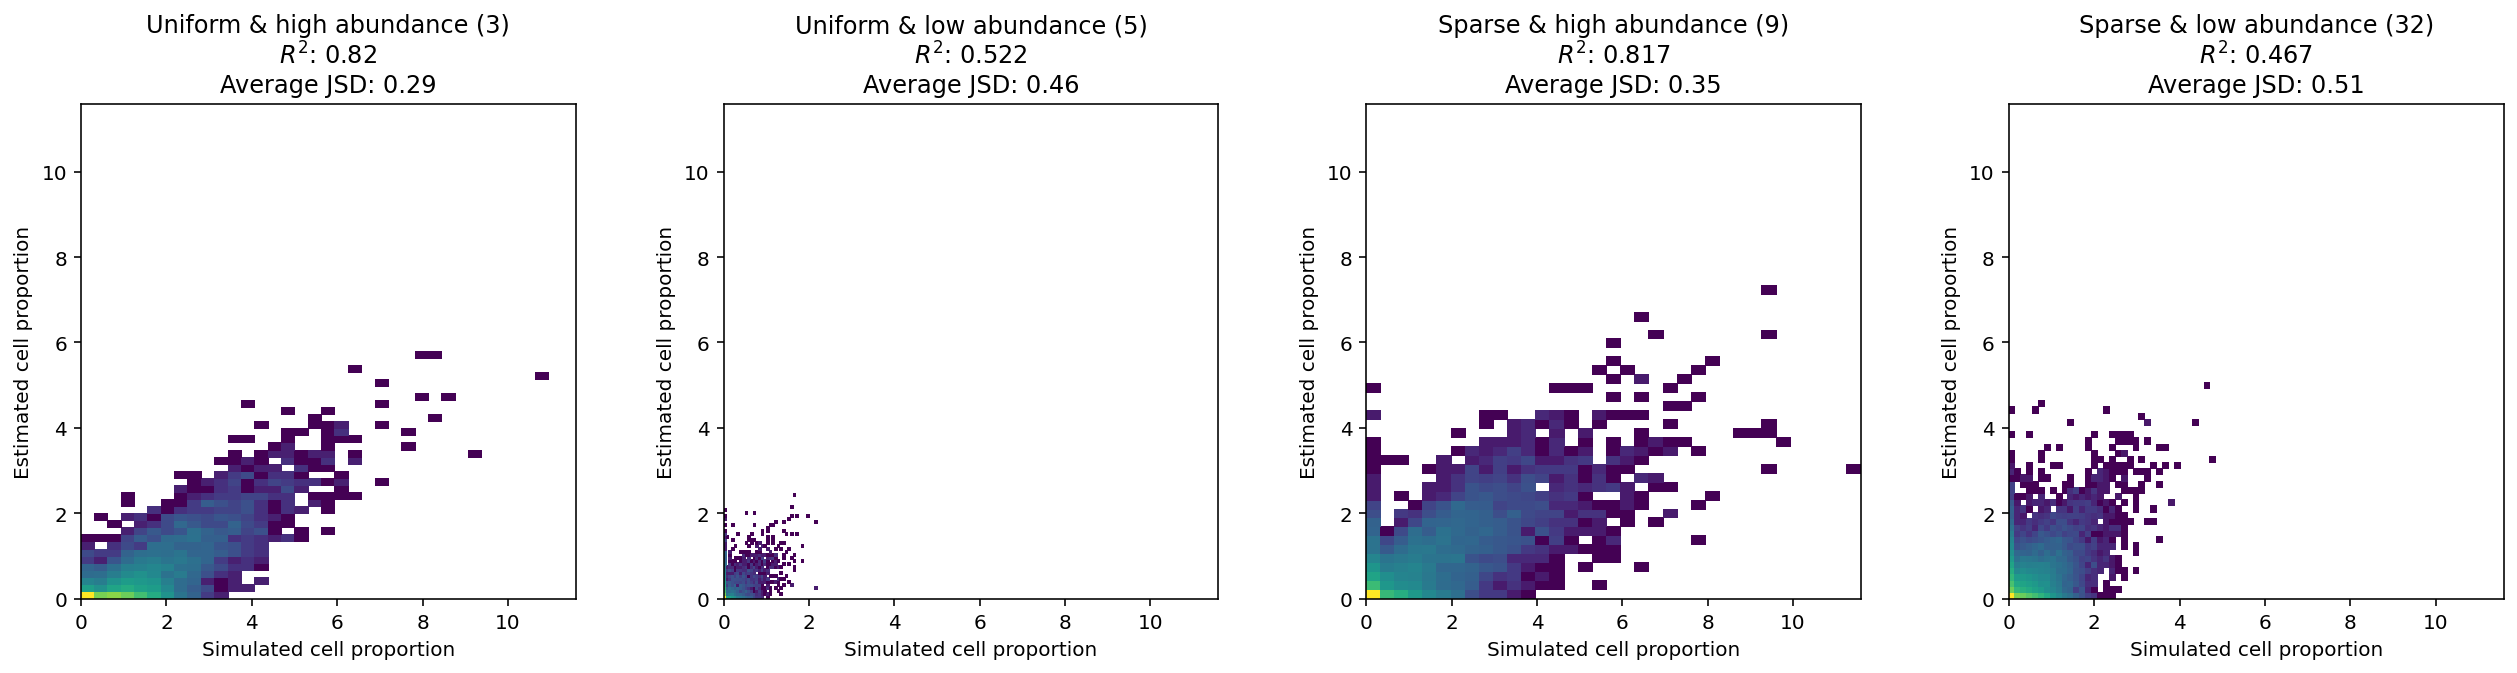

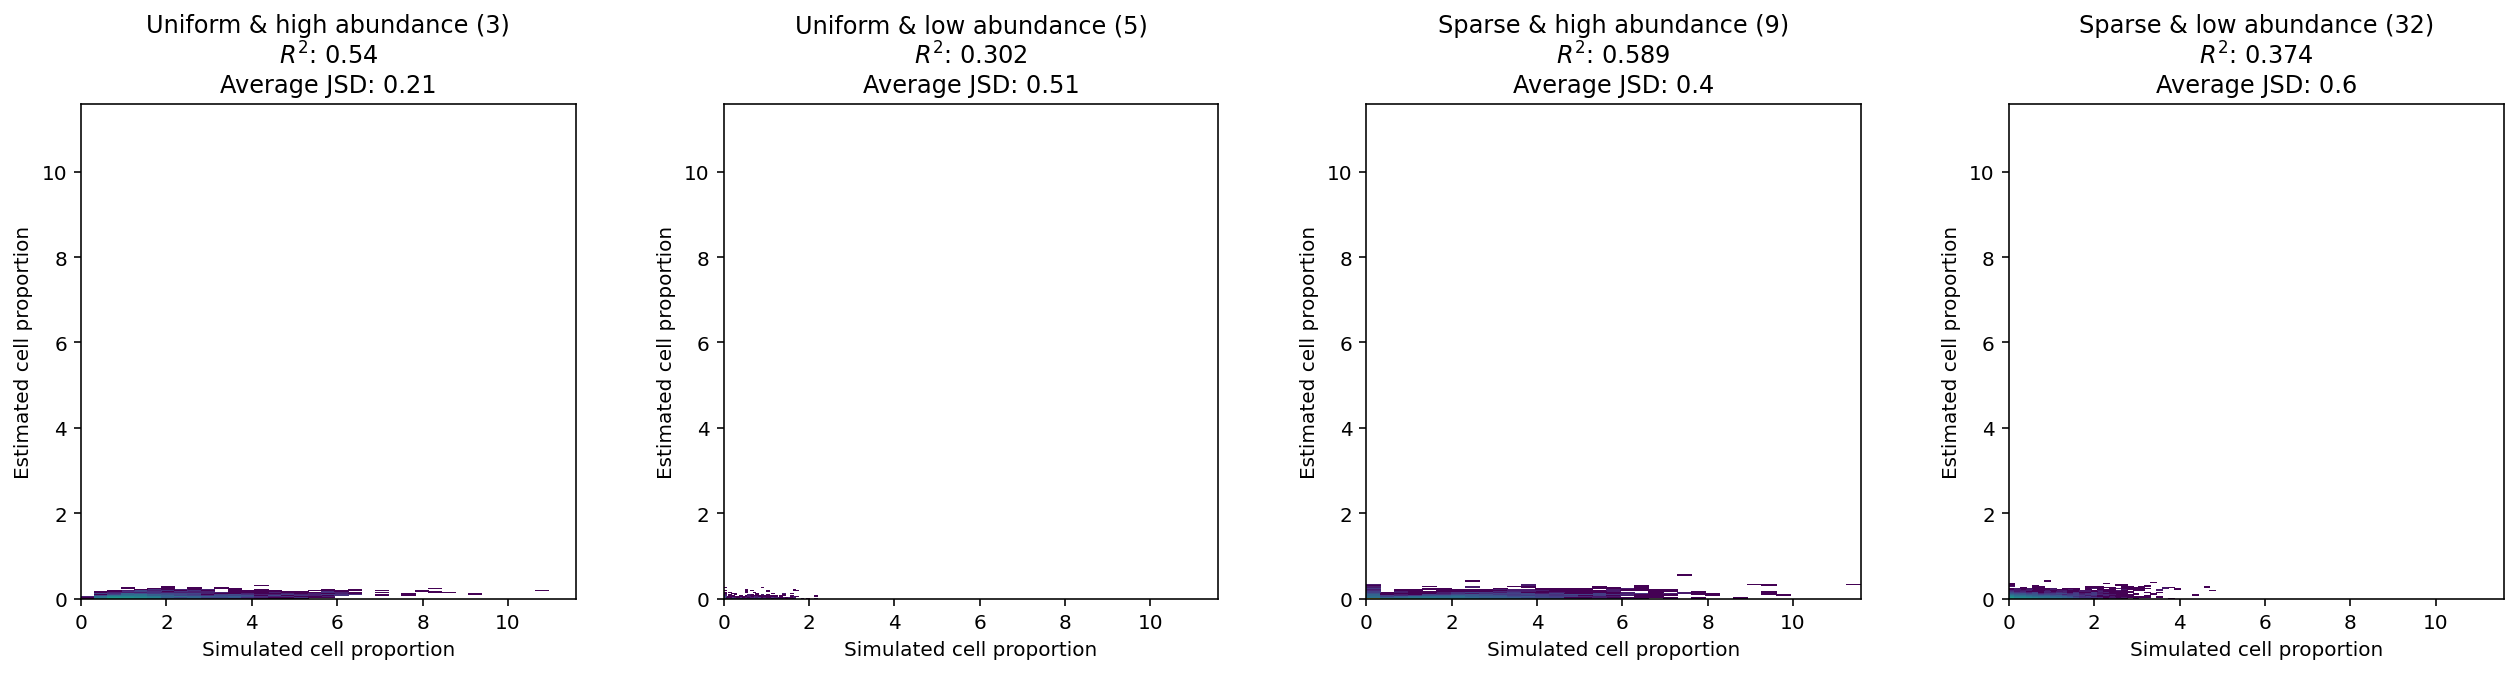

In [19]:
rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
rcParams["axes.facecolor"] = "white"
for i, df in enumerate(method_count_dfs):
    hist_by_category(cell_count, df, adata_vis_res.uns['design']['cell_types2zones'],
                     xlab='Simulated cell proportion',
                     ylab=f'Estimated cell proportion', # {test_names[i]}',
                     #compute_kl=False, 
                     nrow=1, ncol=4, equal=True)
    plt.tight_layout();
    plt.show();

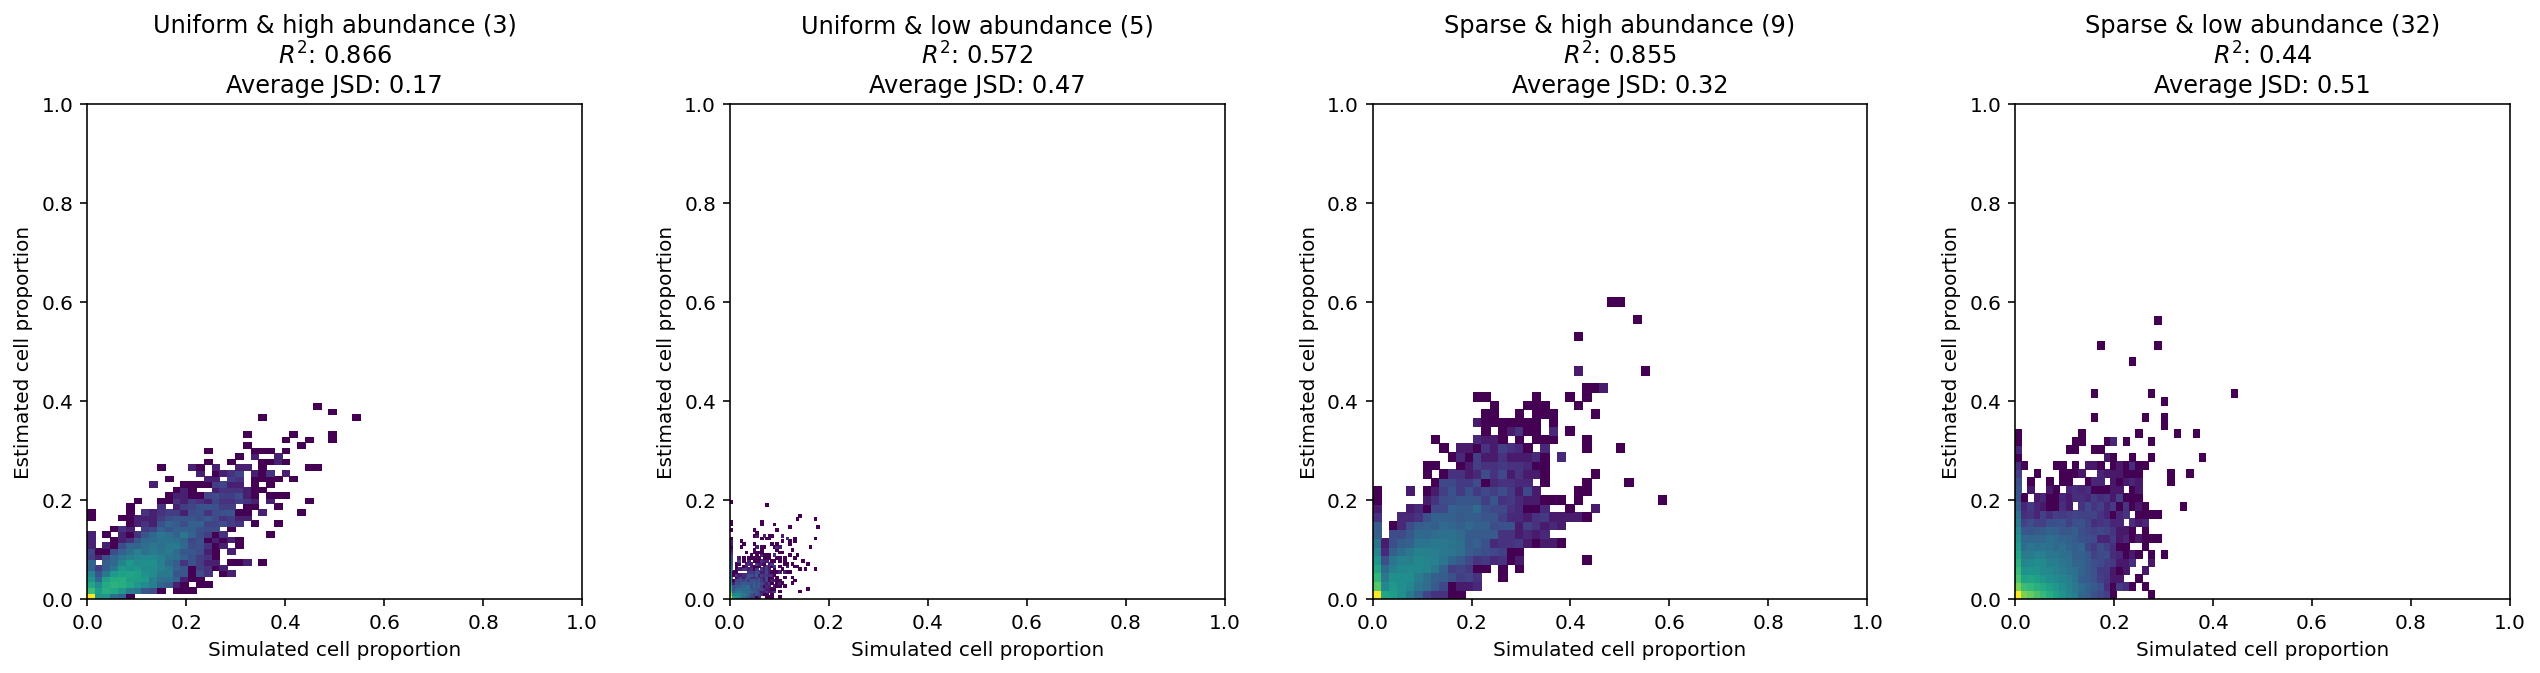

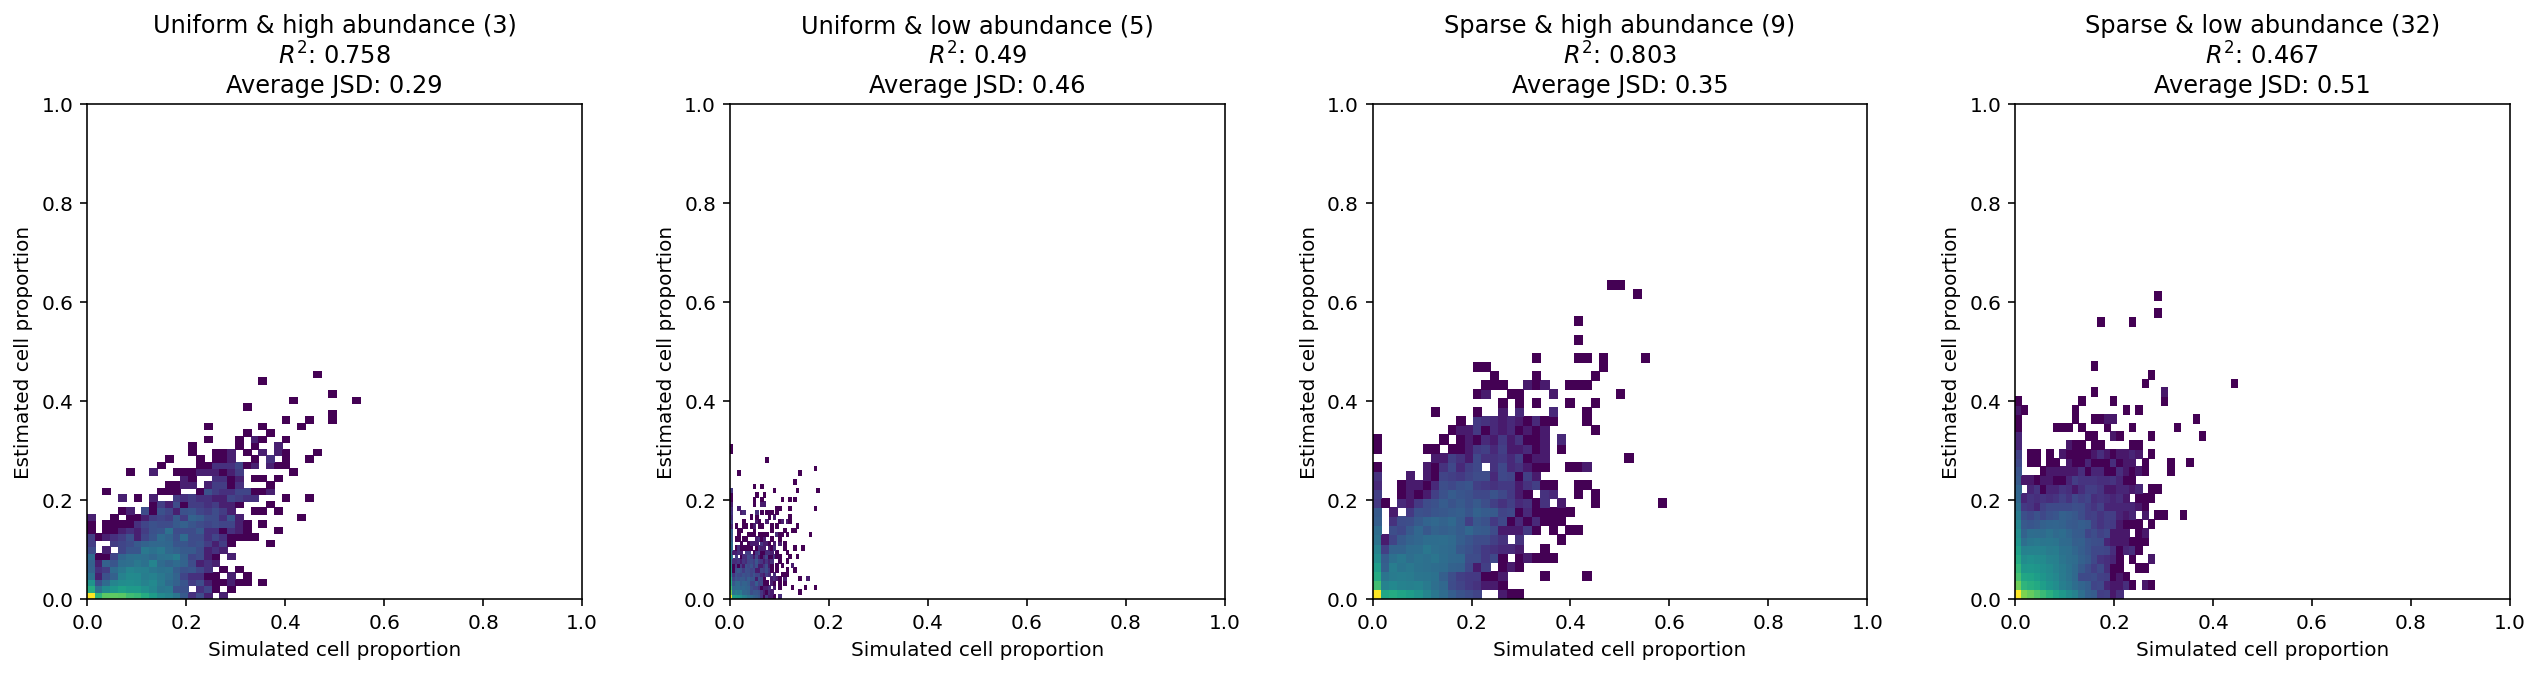

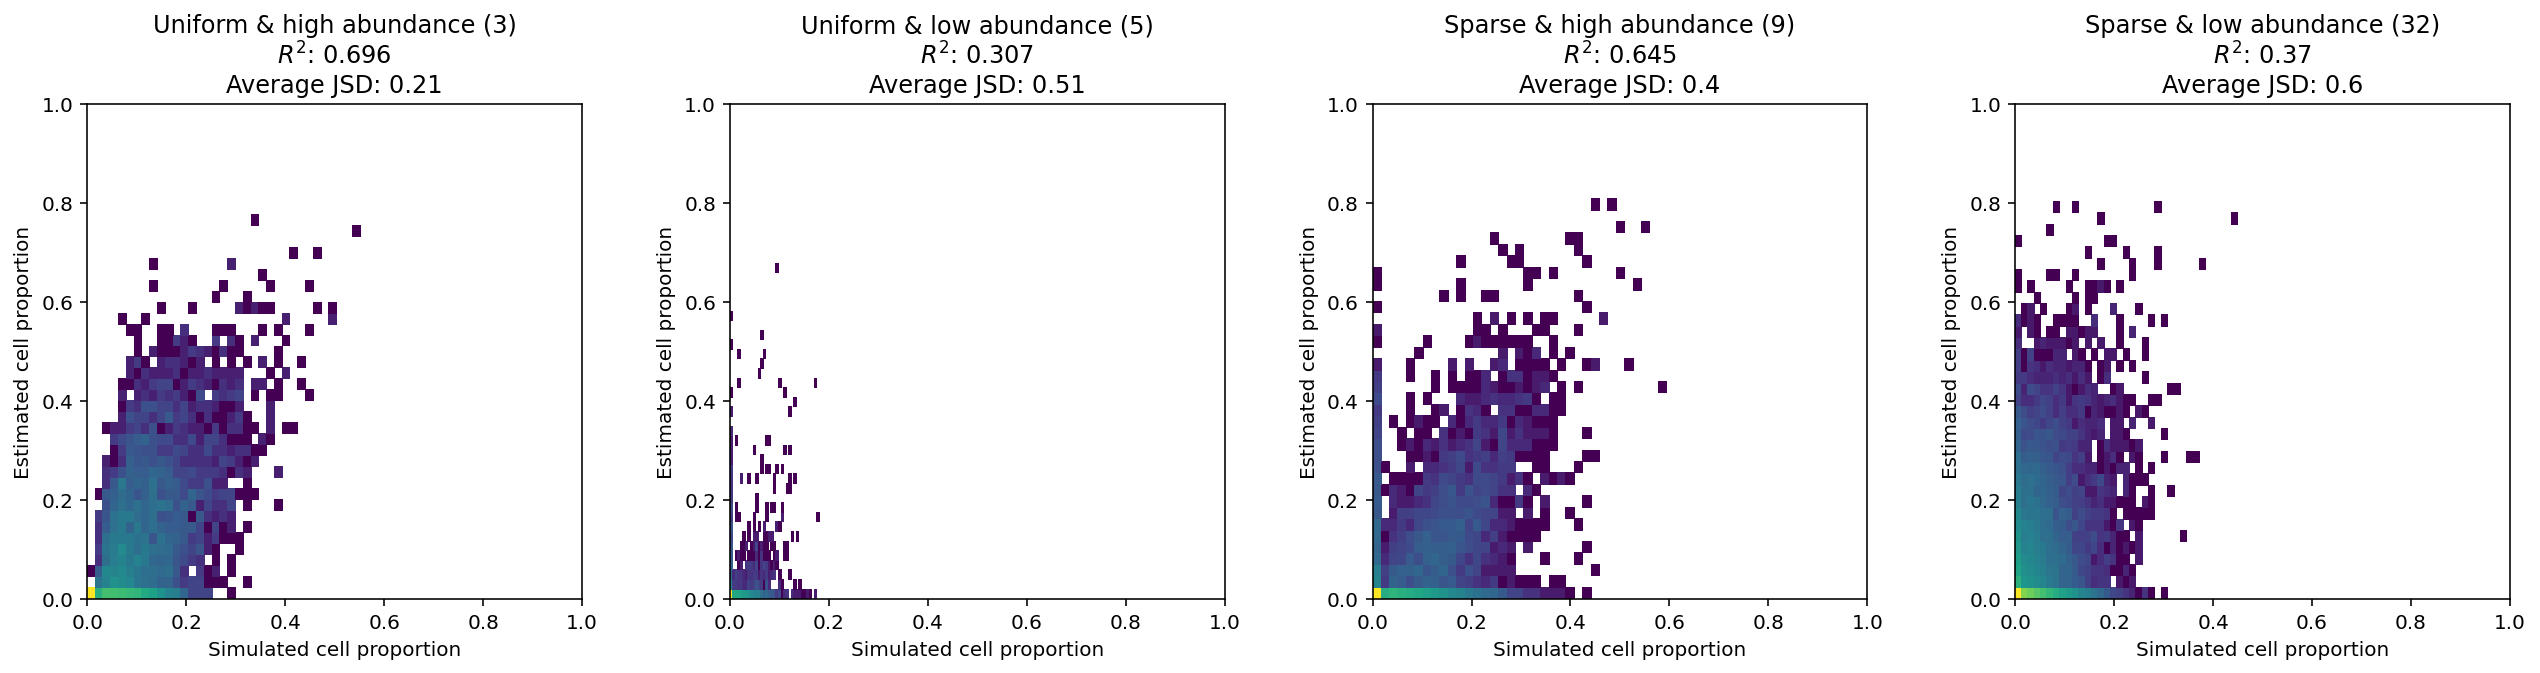

In [20]:
rcParams['figure.figsize'] = 18,4.5 #9,9 #20, 4.5
rcParams["axes.facecolor"] = "white"
for i, df in enumerate(method_dfs):
    hist_by_category(cell_proportions, df, adata_vis_res.uns['design']['cell_types2zones'],
                     xlab='Simulated cell proportion',
                     ylab=f'Estimated cell proportion', #, {test_names[i]}',
                     #compute_kl=False, 
                     nrow=1, ncol=4, equal=True)
    plt.tight_layout();
    plt.show();

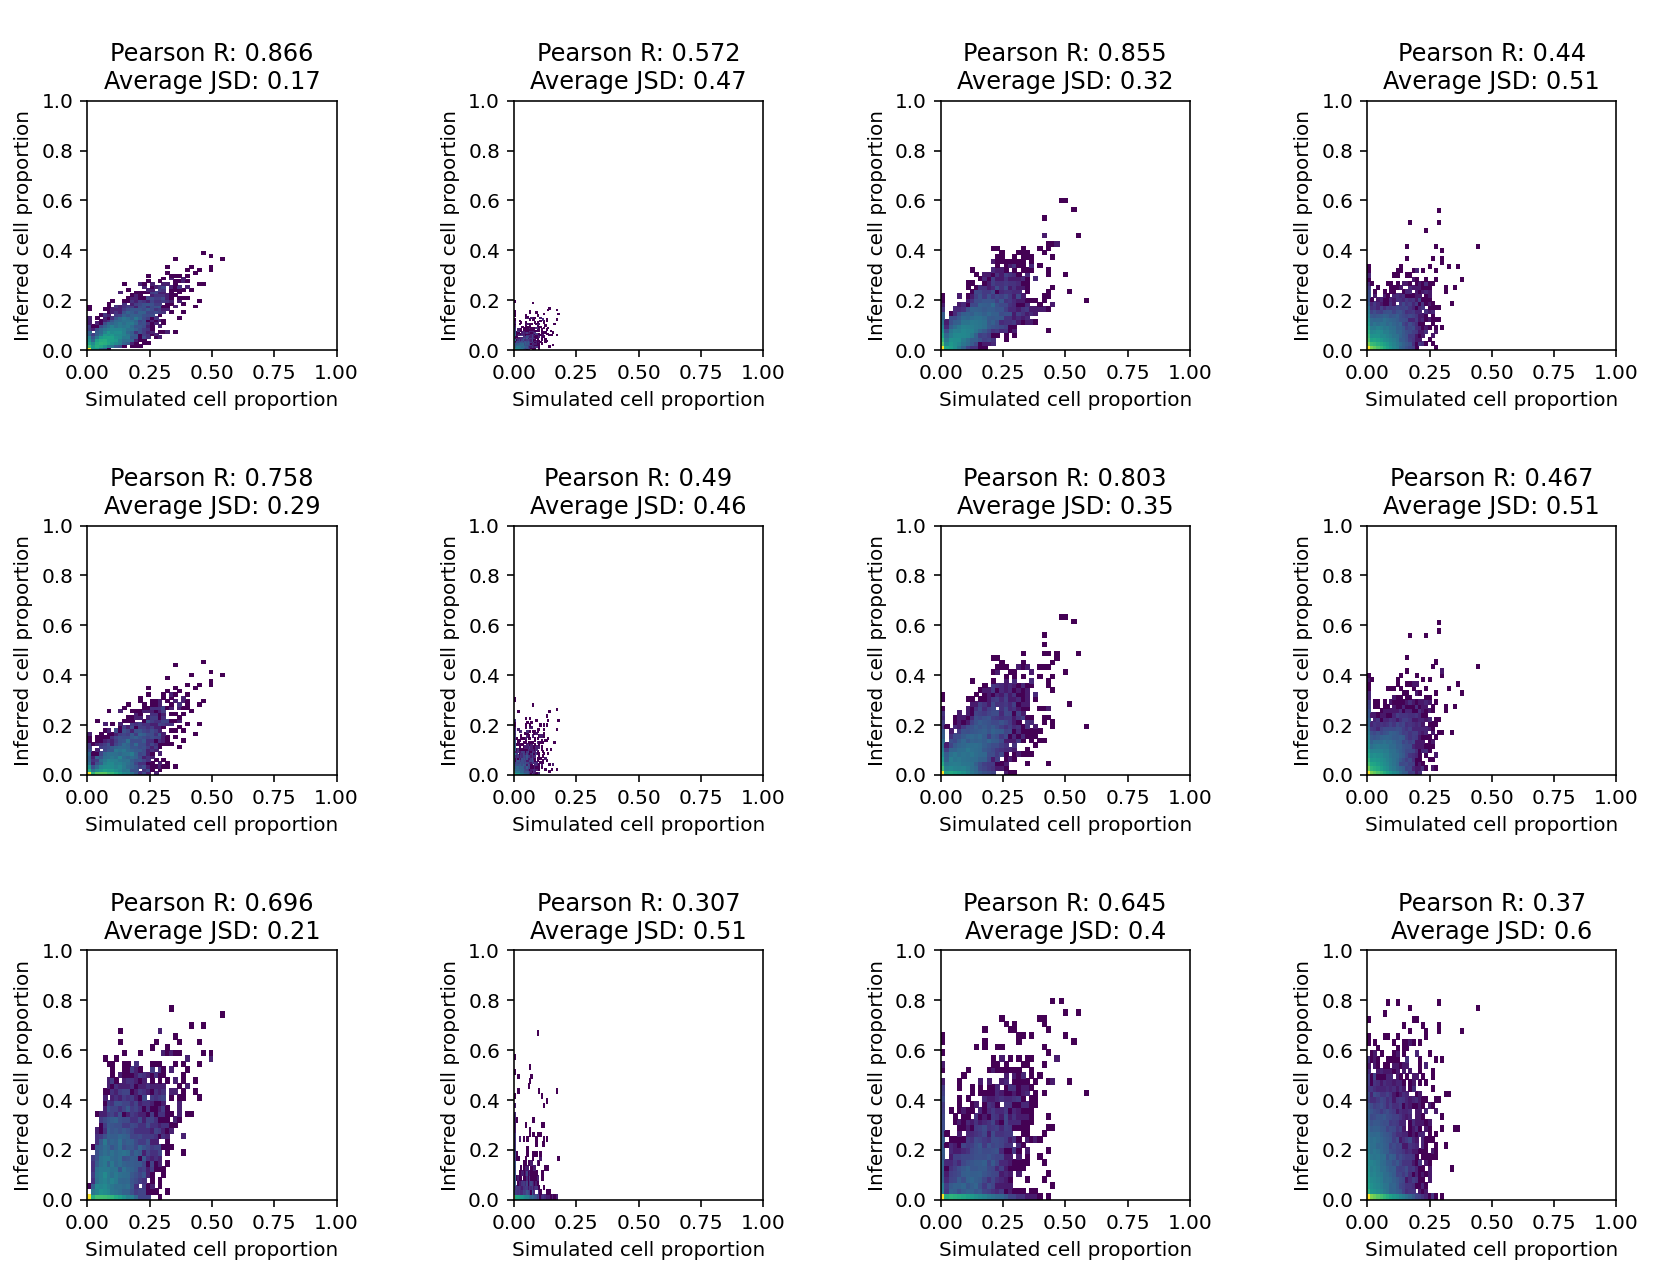

In [21]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)

    return np.sum(np.where(a != 0, a * np.log2(a / b), 0))
from scipy.spatial.distance import jensenshannon

def hist_obs_sim(cell_count, infer_cell_count,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 title='', compute_kl=True, equal=True, max_val=1, ax=None):
    
    if ax is None:
        ax = plt.gca()
    cor = np.round(np.corrcoef(cell_count.values.flatten(), 
               infer_cell_count.values.flatten()), 3)[0,1]
    title = title +'\n'+ r'Pearson R: ' + str(cor)
    
    if compute_kl:
        
        #kl = [KL(cell_count.values[r,:], infer_cell_count.values[r,:]) 
        #         for r in range(cell_count.shape[0])]
        js = np.array([jensenshannon(cell_count.values[r,:], infer_cell_count.values[r,:]) 
                 for r in range(cell_count.shape[0])])
        #kl = np.mean(kl)
        js = np.mean(js[~np.isnan(js)])
        #title = title + '\nAverage KL: ' + str(np.round(kl, 2))
        title = title + '\nAverage JSD: ' + str(np.round(js, 2))
    
    ax.hist2d(cell_count.values.flatten(), 
               infer_cell_count.values.flatten(),
               bins=[35, 35], norm=matplotlib.colors.LogNorm());
    ax.set_xlabel(xlab);
    ax.set_ylabel(ylab);
    if equal:
        ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, max_val);
    ax.set_ylim(0, max_val);
    ax.set_title(title);
    
def hist_by_category(cell_count, infer_cell_count, design,
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion',
                 nrow=1, ncol=4, compute_kl=True, equal=True, axs=None):
    
    if axs is None:
        axs = [None] * 4

    design_loc = design.loc[cell_count.columns,:]
    
    max_val = np.array([cell_count.values.max(), infer_cell_count.values.max()]).max()
    if max_val < 1:
        max_val = 1
    if axs[0] is None:
        plt.subplot(nrow, ncol, 1)
    ind = (design_loc['is_uniform'] * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Uniform & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[0])
    
    if axs[0] is None:
        plt.subplot(nrow, ncol, 2)
    ind = (design_loc['is_uniform'] * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Uniform & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[1])
    
    if axs[0] is None:
        plt.subplot(nrow, ncol, 3)
    ind = ((1 - design_loc['is_uniform']) * design_loc['is_high_density']).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Sparse & high abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[2])
    
    if axs[0] is None:
        plt.subplot(nrow, ncol, 4)
    ind = ((1 - design_loc['is_uniform']) * (1 - design_loc['is_high_density'])).values.astype(bool)
    hist_obs_sim(cell_count.loc[:,ind], infer_cell_count.loc[:,ind],
                 xlab=xlab,
                 ylab=ylab,
                 title='', #f'Sparse & low abundance ({ind.sum()})',
                 compute_kl=compute_kl, equal=equal, max_val=max_val, ax=axs[3])

fig, axs = plt.subplots(len(method_dfs), 4, figsize=(12, 9))

for df, ax in zip(method_dfs, axs):
    hist_by_category(cell_proportions, df, adata_vis_res.uns['design']['cell_types2zones'],
                 xlab='Simulated cell proportion',
                 ylab='Inferred cell proportion', axs=ax)
plt.tight_layout()
plt.savefig(fig_path + '/hist_by_category_all_methods.pdf', bbox_inches='tight')
plt.show()

In [22]:
fig_path

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/with_tissue_zones/real_mg/pyro/hyperparameter_plots/'